# Lab 6: Regression, Confidence Intervals and Credible Intervals
Welcome to the 6th DS102 lab! 

The goal of this lab is to model the numner of named storms in the US. Through this application we will compute and compare confidence intervals and credible intervals. We will perform model predictive checks to validate the 'goodness' of our models and finally we will try to improve our model by adding covariates. Throughout this lab we will always keep in mind the Bayesian and Frequentist perspectives.  


#### The code and responses you need to write are commented out with a message  `TODO: fill in`. There is additional documentation for each part as you go along.

##### Please read carefully the introduction and the instructions to each problem.

## Collaboration Policy
Data science is a collaborative activity. While you may talk with others about the labs, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the cell below.

## Gradescope Submission
To submit this assignment, rerun the notebook from scratch (by selecting Kernel > Restart & Run all), and then print as a pdf (File > download as > pdf) and submit it to Gradescope.


**This assignment should be completed and submitted before Thursday, Oct 15, 2020 at 11:59 PM. PST**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from ipywidgets import interact, interactive
import itertools
import hashlib
from scipy.stats import poisson, norm, gamma
#!pip install pymc3
import statsmodels.api as sm
  
sns.set(style="dark")
plt.style.use("ggplot")

try:
    from pymc3 import *
    import pymc3 as pm
except:
    ! pip install pymc3
    from pymc3 import *
    import pymc3 as pm

import arviz as az

def get_hash(num, significance = 3):
    num = round(num, significance)
    """Helper function for assessing correctness"""
    return hashlib.md5(str(num).encode()).hexdigest()

/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/mcurmei/anaconda3/lib/python3.7/site-packages/statsmodels/compat/pandas.py:23: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  data_klasses = (pandas.Series, pandas.DataFrame, pandas.Panel)


# Atlantic Hurricane Season

With more than 2 months until the end of the year 2020 is on the verge of becoming one of the most active hurricane seasons. So far we have seen 25 named storms close to breaking the 2005 record of 28. Climate scientists argue that the culprit is human induced global warming. There is a an evergrowing body of research linking increased average temperatures and rising sea levels to more frequent, more intense and more destructive storms. 

In this lab we will investigate the number of named storms recorded since 1880, and we will argue that there is a statistically significant relationship between rising Sea Surface Temperature (SST) and the frequency of named storms.

For this lab we extracted the number of tropical storms from the [HURDAT Database](https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2019-052520.txt). We also extracted data on Sea Surface Temperatures from the [National Center for Atmosferic Research](https://climatedataguide.ucar.edu/climate-data/global-surface-temperature-data-gistemp-nasa-goddard-institute-space-studies-giss). 


### Load the data

In [2]:
# No need to modify: Just run the code to load the data
data_source = "hurricane_data.csv"
df = pd.read_csv(data_source)
df = df[["Year", "Num_Storms", "Temp_Anomaly"]]
df.tail()

,Year,Num_Storms,Temp_Anomaly
135,2015,11,1.28
136,2016,15,1.12
137,2017,17,1.10
138,2018,15,1.07
139,2019,18,1.24


The `Num_Storms` column contains the number of named storms recorded each year between 1880 and 2019. The `Temp_Anomaly` column contains the deviation in yearly SST from the mean of 1951-1980.

### Plot the Time Series Data

/Users/mcurmei/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/mcurmei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/mcurmei/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


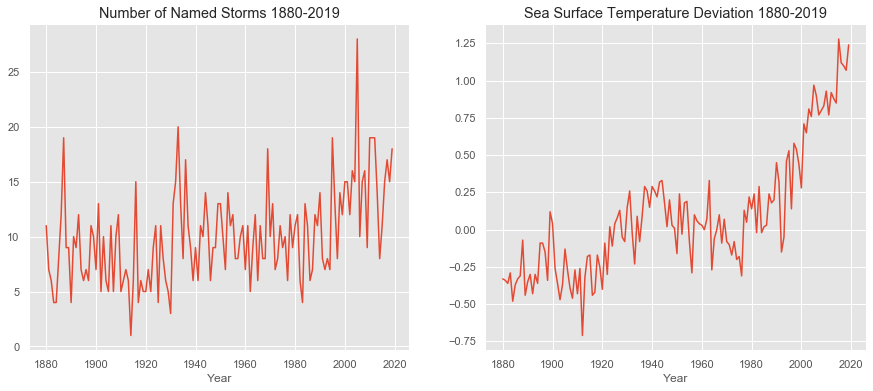

In [3]:
# No need to modify: Just run the code to plot the data
fig, axs = plt.subplots(1, 2)
fig.set_figheight(6)
fig.set_figwidth(15)
axs[0].plot(df.Year, df.Num_Storms)
axs[0].set_title('Number of Named Storms {}-{}'.format(min(df.Year), max(df.Year)))
axs[0].set_xlabel('Year')

axs[1].plot(df.Year, df.Temp_Anomaly)
axs[1].set_title('Sea Surface Temperature Deviation {}-{}'.format(min(df.Year), max(df.Year)))
axs[1].set_xlabel('Year')

plt.show()

# Question 1: Poisson Rate Estimation: Frequentist Perspective

In this question we will attempt to model the yearly counts of Named Storms with a [Poisson Distributions](https://en.wikipedia.org/wiki/Poisson_distribution). Poisson random variables are often used to model count data, so we will use this as our starting point.

Let $C_i$ be the number of storms in year $i$. We assume that $C_i \sim Poisson(\mu)$. Let $N$ be the total number of years in the dataset.

## 1.a.Compute the MLE estimate for the rate $\mu$

The MLE is the solution to the following optimization problem:
$$\hat \mu_{MLE} = \arg\max_{\mu} l(C_1, \ldots, C_N| \mu)$$

The PMF of a Poisson R.V. is $\mathbb{P}\{C_i = k\}=\frac{\mu^k e^{-\mu}}{k!}$. Therefore the log-likelihood of the data is:
$$l(C_1, \ldots, C_N| \mu) = \ln(\mu)\sum_{i=1}^N C_i -N\mu - \sum_{i=1}^N \ln(C_i!)$$

The first derivative of the log-likelihood with respect to the parameter $\mu$ is
$$\frac{d}{d\mu}l(C_1, \ldots, C_N| \mu) = \frac{d}{d\mu} \left( \ln(\mu)\sum_{i=1}^N C_i -N\mu - \sum_{i=1}^N \ln(C_i!) \right) = \frac{1}{\mu}\sum_{i=1}^N C_i - n$$

Imposing that the first derivative be equal to zero, we get:
$$\hat \mu_{MLE} = \frac{1}{N} \sum_{i=1}^N C_i $$

Therefore, the estimator $\hat \mu_{MLE}$ is just the sample mean of the $N$ observations. This makes intuitive sense because the expected value of a Poisson random variable is equal to its rate parameter, and the sample mean is an unbiased estimator of the expected value.

### TODO: Complete the function below to compute the MLE estimate for a Poisson Model

In [4]:
# TODO: complete the funtion
def get_MLE_estimate(counts):
    """
    Computes the MLE estimate
    
    Inputs:
        counts: array of ints, counts[i] - # of named storms in year i
    
    Output:
        estimate: float, MLE estimate for the Poisson rate
    """
    estimate = np.mean(counts) #TODO: fill in
    return(estimate)    

In [5]:
# Validation tests, do not modify
val_counts = df.Num_Storms + 3
hash_val = 'ef7fef4024203f304b84e13cba2fd9b9'
assert get_hash(get_MLE_estimate(val_counts)) == hash_val
print('Test Passed!')
print("The MLE estimate for the rate of storms per year is {:.2f}".format(get_MLE_estimate(df.Num_Storms)))

Test Passed!
The MLE estimate for the rate of storms per year is 10.02


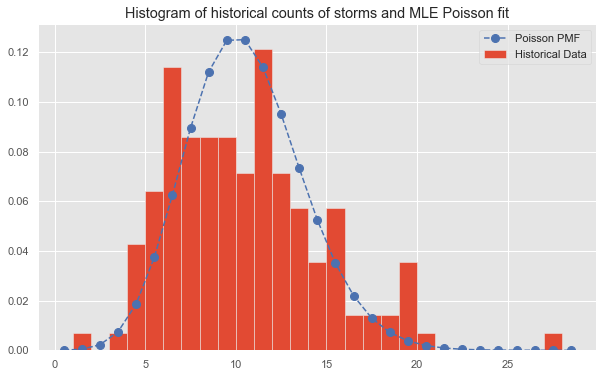

In [6]:
# Plot the histogram: No need to modify
fig = plt.figure(figsize = (10, 6))
plt.hist(df.Num_Storms, bins = 27, label="Historical Data", density=True)
x = np.arange(0, max(df.Num_Storms)+1)
mu_mle = get_MLE_estimate(df.Num_Storms)
plt.plot(x+0.5, poisson.pmf(x, mu_mle), 'bo--', ms=8, label='Poisson PMF')
plt.title("Histogram of historical counts of storms and MLE Poisson fit")
plt.legend()
plt.show()

## 1.b Compute Confidence Intervals via Asymptotic Theory

### Confidence Interval

Let $\mu^*$ is the true unknown Poisson rate parameter. And let $C = \{C_1, C_2, \ldots, C_N\}$ be the count data.

A $(1-\alpha)\cdot 100\%$ Confidence Intercal is an interval of the form $[lower(C), upper(C)]$ such that:
$$\mathbb{P}_{\mu^*}\left( [lower(C), upper(C)] \ni \mu^*\right) >= 1-\alpha$$

#### _You can interpret the above as: If I were to repeat this experiment $t = 1, 2, \ldots 1000$ times, and get new realizations of the data: $C^{t}$, then  $(1-\alpha)\cdot 1000$ of the resulting intervals of the form $[lower(C^t), upper(C^t)]$ will 'cover' the true parameter $\mu^*.$_
`Note:` In the Frequentist world $\mu^*$ is not a Random Variable, so it does not make sense to say: The probability that $\mu^*$ belongs to the interval $[lower(C), upper(C)]$ is $1-\alpha$. This is a subtle but very important distinction.

### Asymptotic Approximation
Central Limit Theorem for samples from Poisson distribution states that:
$$\hat\mu_{MLE} - \mu^* \approx Normal\left(0, \underbrace{\frac{\hat\mu_{MLE}}{N}}_{\hat \sigma^2}\right)$$

Let $\alpha = 0.05$, then:

$$\mathbb{P}\left([\mu_{MLE} - 1.96\hat \sigma, \mu_{MLE} + 1.96\hat \sigma] \ni \mu^*\right)\approx 0.95$$

Hence $\hat\mu_{MLE}\pm 1.96\sqrt{\frac{\hat\mu_{MLE}}{N}}$ is an approximate 95% confidence interval for $\mu^*$. 

### TODO: Complete the function below to compute confidence intervals

In [7]:
# TODO: complete the function
def get_asymptotic_CI(mu_MLE, N):
    """
    Computes the asymptotic 95% confidence interval
    
    Inputs:
        mu_MLE: float, the MLE estimate
        N: int, number of data points
        
    Outputs:
        lower: float, lower bound of the 95% confidence interval
        upper: float, upper bound of the 95% condidence interval
    """
    variance = mu_MLE/N
    lower = mu_MLE - 1.96*np.sqrt(variance)  # TODO: fill in
    upper = mu_MLE + 1.96*np.sqrt(variance)  # TODO: fill in
    return(lower, upper)

In [8]:
# Validation Tests: Do not modify
mu_vals = [2, 5, 10]
N_vals = [10, 50, 100]
inputs = list(itertools.product(mu_vals, N_vals))
outputs = [get_asymptotic_CI(*inp) for inp in inputs]
hash_list_l = ['e019ca23aedfa87718492570baac57da', 'd73d83219540f0ba46ce862a873ff209', 
               '973d88988f3f8540514424e364f55fb7', '1ff894cb9180b784e9635bb8bb225422',
               '27579832aefeab09b92d03cfb4ea616c', 'a7020466497a0a29280fe11b85d51e42',
               '50548546fc2d009d6ce9d4f9a7a024b9', '166055cfdc08b889870f1e7912fc421c', 
               '390e085b69e5bc32001120861e412300']
hash_list_u = ['0e6ca06b16cf1a54ca2656273678c277', '05d219fadea25205b25f098c3a8dd052', 
               '0b6d332c2d3459b55ff870cdd5775342', 'a9138612c8c18b2875f89495820f8f5e',
               'ae840f51bfecfe26ea8843de21332309', '37845f067b1607e415272d05102b0815',
               '953003c28cb70d3828872a6e0609f055', 'a53f0a0d9a2a2b8e1041777f1bf1b60f', 
               '4ebc9eec7720d57b742c90115c3ee49f']
for i, out in enumerate(outputs):
    assert hash_list_l[i] == get_hash(out[0])
    assert hash_list_u[i] == get_hash(out[1])
print("Test passed!")
print("The asymptotic 95% confidence intervals for the rate of storms per year is ({:.2f}-{:.2f})".
      format(*get_asymptotic_CI(get_MLE_estimate(df.Num_Storms), len(df.Num_Storms))))

Test passed!
The asymptotic 95% confidence intervals for the rate of storms per year is (9.50-10.55)


## 1.c Compute Estimate for the Rate and Confidence Intervals Using the Bootstrap Method

Appealing to asymptotic theory is one way of computing Confidence Intervals. Another technique we learned in class is the Bootrap Method. We can use it to estimate both the mean rate and the corresponding confidence intervals.

The Bootstrap procedure proceeds as follows:

Let `B:=num bootstrap samples` 
- for `b=1,2...B`:
    - get bootstrap samples: $C^{*(b)}_1, C^{*(b)}_2, \ldots, C^{*(b)}_N$
    - compute bootstrap sample estimate: $\bar C^{*(b)} = \frac{C^{*(b)}_1, C^{*(b)}_2, \ldots, C^{*(b)}_N}{N}$
- compute mean estimate: $\bar C^* = \frac{\sum_{b=1}^B \bar C^{*(b)}}{B}$
- compute $(1-\alpha)$ confidence intervals:
    - `lower_bound`: The $\alpha/2$ percentile of the array $[ C^{*(1)},  C^{*(2)}, \ldots ,  C^{*(N)} ]$
    - `upper_bound`: The $(1-\alpha/2)$ percentile of the array $[ C^{*(1)},  C^{*(2)}, \ldots ,  C^{*(N)}]$
    
### TODO: Complete the function below to compute boostrap estimate and confidence intervals

In [9]:
# TODO: complete the function
def get_bootstrap_estimate_CI(counts, B=1000):
    """
    Computes bootstrap estimates of the rate and confidence interval.
    
    Inputs:
        counts: array of ints, counts[i] - # of named storms in year i
        B: int, number of bootstrap samples
    
    Outputs:
        estimate: the bootstrap estimate for the rate
        lower: float, lower bound of the 95% confidence interval via bootstrap
        upper: float, upper bound of the 95% condidence interval via bootstrap
    """
    n = len(counts)
    bootstrap_means = np.zeros(B)
    for b in range(B):
        bootstrap_sample = np.random.choice(counts, size=n, replace=True)
        bootstrap_means[b] = np.mean(bootstrap_sample)   
    estimate = np.mean(bootstrap_means)
    upper = np.percentile(bootstrap_means, 97.5)
    lower =  np.percentile(bootstrap_means, 2.5)
    return(estimate, lower, upper)

In [10]:
# Validation tests: Do not modify
val_counts = df.Num_Storms + 3
output = get_bootstrap_estimate_CI(val_counts, B=1000)
assert np.abs(output[0] -13) < 0.2
assert np.abs(output[1] -12.35) < 0.2
assert np.abs(output[2] -13.7) < 0.2
print("Test Passed!")
print("Bootstrap estimate of the rate and 95% confidence interval: {:.2f} ({:.2f}-{:.2f})".
     format(*get_bootstrap_estimate_CI(df.Num_Storms, B=1000)))

Test Passed!
Bootstrap estimate of the rate and 95% confidence interval: 10.04 (9.34-10.76)


# Question 2: Poisson Rate Estimation: Bayesian Perspective

In Question 1 we computed the mean rate of yearly named storms in the US from a Frequentist perspective. In **1.a, 1.b** we computed the MLE estimate along with Confidence Intervals derived from Asymptotic Theory (CLT). In **1.c** we estimated the mean rate and Confidence Intervals via Bootstrap samples.

In this question we will employ a Bayesian perspective.

### Gamma-Poisson Model

- Prior: $\mu \sim Gamma(a, b)$

- Likelihood: $C_i|\mu \sim Poisson(\mu)$

Based on the prior and likelihood we can derive the posterior distribution:
- Posterior: $\mu|C_1, C_2, \ldots, C_N \sim Gamma(a + \sum_{i=1}^N C_i,b + N)$ 

`Note:` Revisit Problem 3 in Discussion 4. There we prove that Gamma-Poisson is a conjugate prior model.

## 2.a Compute Posterior Mean Estimate
Having the analytical form of the posterior distribution we can compute point estimates. Common choices are MAP estimates and posterior mean estimate.

In this question we will compute the posterior mean estimate: $\hat\mu_{PM} := \mathbb{E}(\mu|C_1, C_2, \ldots, C_N)$

### TODO: Complete the function below to compute the posterior mean
`Hint:` Recall that the expectation of $X\sim Gamma(a', b')$ is $\frac{a'}{b'}$

In [11]:
# TODO: complete the function
def get_PM_estimate(counts, a=10, b=1):
    """
    Computes the posterior mean estimate
    
    Inputs:
        counts: array of ints, counts[i] - # of named storms in year i
        a: float, shape parameter of the prior Gamma distribution
        b: float, scale parameter of the prior Gamma distribution
        
    Output:
        estimate: float, posterior mean estimate
    """
    estimate = (a + np.sum(counts))/(b + len(counts)) # TODO: fill in
    return(estimate)

In [12]:
# Validation tests: Do not modify
val_counts = df.Num_Storms+2
a_vals = [10, 20]
b_vals = [1, 10]
inputs = list(itertools.product(a_vals, b_vals))
outputs = [get_PM_estimate(val_counts, *inp) for inp in inputs]
hash_list = ['ef9bcfe95da1fa16a916a4813ada87a5', '1df9efbe3c47ec2a9fb1628adba6d6b6', 
             'b616158bd896a3059386cf26dbe94e8f', 'fb640eab6a90a359b9801c013f8151ca']
for i, out in enumerate(outputs):
    assert hash_list[i] == get_hash(out)
print("Test passed!")  
a = 10
b = 1
print("The posterior mean estimate for the rate of storms per year is {:.2f} (Prior: Gamma({},{}))".
     format(get_PM_estimate(df.Num_Storms, a, b), a, b))

Test passed!
The posterior mean estimate for the rate of storms per year is 10.02 (Prior: Gamma(10,1))


## 2.b Compute Credible Intervals

In the Bayesian world, the data: $C = \{C_1, C_2, \ldots C_N\}$ is fixed and the rate parameter $\mu$ is random variable.

A $(1-\alpha)\cdot100\%$ Credible Interval is a interval of the form: $[lower(C), upper(C)]$ such that:

$$\mathbb{P}\{\mu \in [lower(C), upper(C)]|C\} \geq 1-\alpha$$

`Note:` Unlike the Frequentist perspective, the above can be read as: 
**The probability that $\mu|C$ belongs to the confidence interval $[lower(C), upper(C)]$ is at least $1-\alpha$.**

In this case we have the full posterior distribution $\mu|C \sim \Gamma(a + \sum_{i=1}^N C_i, b + N)$. Hence one common choice for the Credible Interval is $[\mu^{(\alpha/2)}, \mu^{(1-\alpha/2)}]$.

Where $\mu^{(\alpha/2)}$ and $\mu^{(1-\alpha/2)}$ are the $\alpha/2$ and $(1- \alpha/2)$ percentiles of the posterior distribution of $\mu$. 

### TODO: Compute 95% Credible Intervals
`Hint`: The percentile function is the inverse of the CDF function. Percentile values can be computed directly with [`gamma.ppf(quantile, a, scale = 1/b)`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html) function. (note that the default parametrization in scipy is `(shape, rate) = (shape, 1/scale)`)

In [13]:
# TODO: complete the function
def get_equal_tail_CI(counts, a=10, b=1):
    """
    Computes the posterior mean estimate
    
    Inputs:
        counts: array of ints, counts[i] - # of named storms in year i
        a: float, shape parameter of the prior Gamma distribution
        b: float, scale parameter of the prior Gamma distribution
        
    Output:
        lower: float, lower bound of the 95% credible interval 
        upper: float, upper bound of the 95% credible interval 
    """
    
    lower = gamma.ppf(0.025, a+ np.sum(counts), scale = 1/(b+ len(counts))) # TODO: fill in
    upper = gamma.ppf(0.975, a+ np.sum(counts), scale = 1/(b+ len(counts))) # TODO: fill in
    return(lower, upper)

In [14]:
# Validation tests: Do not modify
val_counts = df.Num_Storms+5
a_vals = [10, 20]
b_vals = [1, 10]
inputs = list(itertools.product(a_vals, b_vals))
outputs = [get_equal_tail_CI(val_counts, *inp) for inp in inputs]
hash_list_l =['0b1ed4a354c74ee10ed6e6717b512866', '467744503d1952807eac25b78597e0fe', 
              '545345bacef53af79874ba78b0dbbab2', '56e7145beb0a5eaae9d8b792f93d97e9']
hash_list_u =['171edc859f921f46887d078d4e122f67', '876c7d8ec26bfa066670ecbf0dd810fc',
              '46321df7cbf31938ff684631ab321c49', 'a703143a5f6589344b07801c50bdb94e']
for i, out in enumerate(outputs):
    assert hash_list_l[i] == get_hash(out[0])
    assert hash_list_u[i] == get_hash(out[1])
print("Test passed!")  
a = 10
b = 1
print("The credible interval for the rate of storms per year is ({:.2f}-{:.2f}).  (Prior: Gamma({},{}))".
     format(*get_equal_tail_CI(df.Num_Storms, a, b), a, b))

Test passed!
The credible interval for the rate of storms per year is (9.51-10.55).  (Prior: Gamma(10,1))


## 2.c Compare Frequentist and Bayesian Estimates

In [15]:
# No TODOs: Just run this once you pass all the validation tests above

# MLE estimate and asymptotic Confidence Interval
mu_MLE = get_MLE_estimate(df.Num_Storms)
mu_asymptotic_lower, mu_asymptotic_upper = get_asymptotic_CI(mu_MLE, N = len(df.Num_Storms))

# Bootstrap estimate and Confidence Interval
mu_BS, mu_BS_lower, mu_BS_upper = get_bootstrap_estimate_CI(df.Num_Storms, B=1000)

# Bayesian Posterior Mean estimate and Equal Tail Credible Interval
mu_PM = get_PM_estimate(df.Num_Storms)
mu_ET_lower, mu_ET_upper = get_equal_tail_CI(df.Num_Storms)

In [16]:
# Print values: Helper function, do not modify
def printer(text, est, low, upp):
    final_text = '{}: {:.3f} ({:.3f}-{:.3f})'.format(text, est, low, upp)
    print(final_text)

printer("MLE Estimate and Asymptotic Confidence Interval", mu_MLE, mu_asymptotic_lower, mu_asymptotic_upper)
printer("Bootstrap Estimate and Confidence Interval", mu_BS, mu_BS_lower, mu_BS_upper)
printer("Posterior Mean Estimate and Credible Interval", mu_PM, mu_ET_lower, mu_ET_upper)

MLE Estimate and Asymptotic Confidence Interval: 10.021 (9.497-10.546)
Bootstrap Estimate and Confidence Interval: 10.019 (9.321-10.736)
Posterior Mean Estimate and Credible Interval: 10.021 (9.506-10.550)


### TODO: Compare the various intervals above. Write 1 sentence of your observations. Comments on whether the estimates and CIs of the 3 methods are close to each-other and whether the CIs are narrow or wide.

`TODO`: fill in

### For each estimation procedure plot the Poisson PMFs corresponding to the estimate as well as the lower and upper bound of the CIs. Overlay the histogram of historical data.
No TODOs here, just run the code and inspect the plots

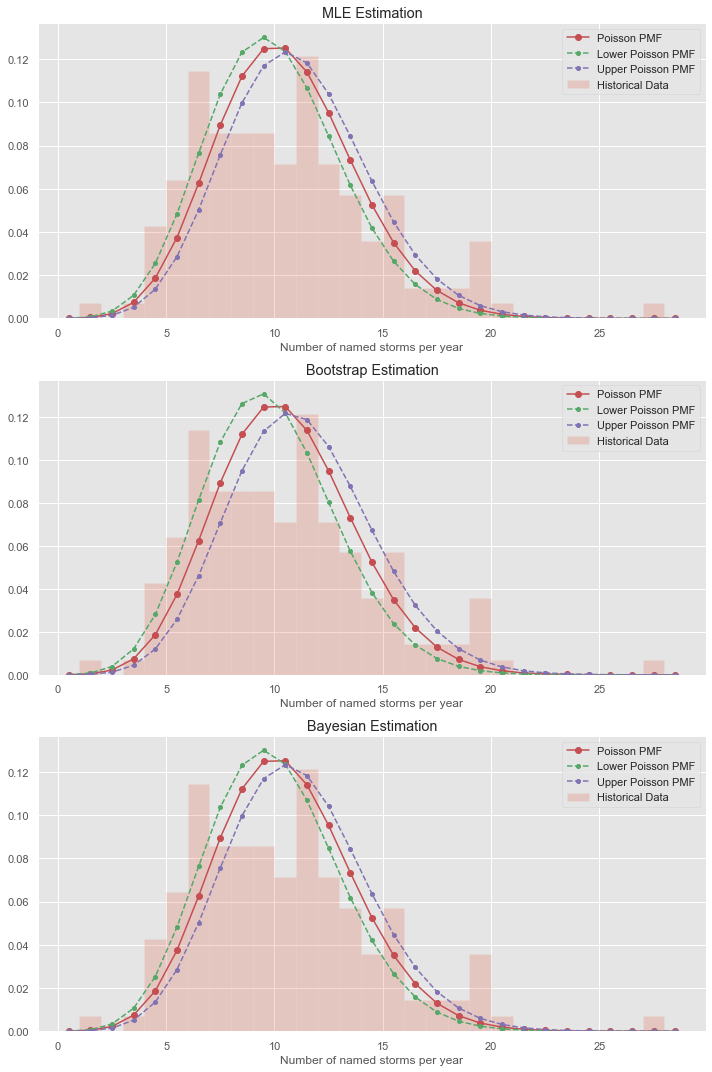

In [17]:
# Plot the histogram: No need to modify
def plot_data_model(ax, est, low, upp, title = ''):
    ax.hist(df.Num_Storms, bins = 27, label="Historical Data", density=True, alpha = 0.2)
    x = np.arange(0, max(df.Num_Storms)+1)
    ax.plot(x+0.5, poisson.pmf(x, est), 'bo-', ms=6, label='Poisson PMF', color = 'r')
    ax.plot(x+0.5, poisson.pmf(x, low), 'bo--', ms=4, label='Lower Poisson PMF', color = 'g')
    ax.plot(x+0.5, poisson.pmf(x, upp), 'bo--', ms=4, label='Upper Poisson PMF', color = 'm')
    ax.set_xlabel("Number of named storms per year")
    ax.set_title(title)
    ax.legend()
    return(ax)

fig, axs = plt.subplots(3, 1)
fig.set_figheight(15)
fig.set_figwidth(10)
plot_data_model(axs[0], mu_MLE, mu_asymptotic_lower, mu_asymptotic_upper, title="MLE Estimation")
plot_data_model(axs[1], mu_BS, mu_BS_lower, mu_BS_upper, title = "Bootstrap Estimation")
plot_data_model(axs[2], mu_PM, mu_ET_lower, mu_ET_upper, title = "Bayesian Estimation")

plt.tight_layout()
plt.show()

The plots above suggest that a Poisson model might not fit the data too well. This modeling assumptions leads to over-confident rate estimates. In class you saw one approach to address this: using a Negative Binomial to model the count data. This could give better results for our dataset since we observe some over-dispersion.

In Question 3 we will attempt to address the model mis-specification problem. However, instead of modeling the number of named storms per year as a Negative Binomial, we will introduce the Sea Surface Temperature covariate.

# Question 3: Poisson Regression

In this question we will model the number of named storms in Year $i$ as: 
$C_i \sim Poisson(\lambda_i)$, where $\lambda_i = exp(q_0 + q_1 X_i)$, and $X_i$ is the SST deviation in Year $i$.

This is no longer something that we can easily solve from scratch, so we have to use software packages. For Frequentist Poisson Regression we will use [`statsmodels.api`](https://www.statsmodels.org/stable/glm.html) and for the Bayesian counterpart we will use [`PYMC3`]().

## 3.a Frequentist Regression

In [18]:
# Fit Poisson GLM model where Temp_Anomaly is a covariate (exogenoug variable): No need to modify
freq_model = sm.GLM(df.Num_Storms, exog = sm.add_constant(df.Temp_Anomaly), 
                  family=sm.families.Poisson())
freq_res = freq_model.fit()
print(freq_res.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             Num_Storms   No. Observations:                  140
Model:                            GLM   Df Residuals:                      138
Model Family:                 Poisson   Df Model:                            1
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -376.25
Date:                Sun, 25 Oct 2020   Deviance:                       183.00
Time:                        20:46:43   Pearson chi2:                     186.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.2414      0.029     78.130   

### TODO: (iii) Inspecting the results of fitting `freq_model`. Does the model suggest that increased SST relate to more storms? Is the influnce of SST on number of storms statistically significant?

Yes, the coefficient corresponding to SST is 0.487 and the 95\% CI is 0.370-0.603, which is signifantly larger than 0. The coefficient being positive means that increases in SST correspond to increases in number of named storms.

Your friend wants to model $C_i \sim Poisson(\lambda)$ as in **Q.1.**. However, they decide to take a shortcut and use the `sm` package to compute the estimate of the rate and CIs without `Temp_Anomaly` covariate. Your friend runs the code in the cell below:

In [19]:
# No need to modify
mle_model = sm.GLM(df.Num_Storms, exog = np.ones_like(df.Num_Storms), 
                  family=sm.families.Poisson())
mle_res = mle_model.fit()
print(mle_res.summary(title = "Poisson Model without Covariates"))

                       Poisson Model without Covariates                       
Dep. Variable:             Num_Storms   No. Observations:                  140
Model:                            GLM   Df Residuals:                      139
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -407.96
Date:                Sun, 11 Oct 2020   Deviance:                       246.41
Time:                        21:58:05   Pearson chi2:                     253.
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3047      0.027     86.327      0.0

Your friend argues that his output is essentially the same as the one you got in **1.a-1.b**

### TODO: (ii) Do you agree with your friend? Why/why not?

Yes! There is a correspondence between the two. $e^{2.3} \approx 10$

## 3.b Bayesian Regression

In [19]:
# No need to modify
with pm.Model() as bayes_model:
    glm.GLM.from_formula('Num_Storms ~ Temp_Anomaly', df, family=glm.families.NegativeBinomial()) 
    # PYMC3 automatically uses exponential link function and adds an intercept term
    trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, mu, Temp_Anomaly, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1103.36draws/s]


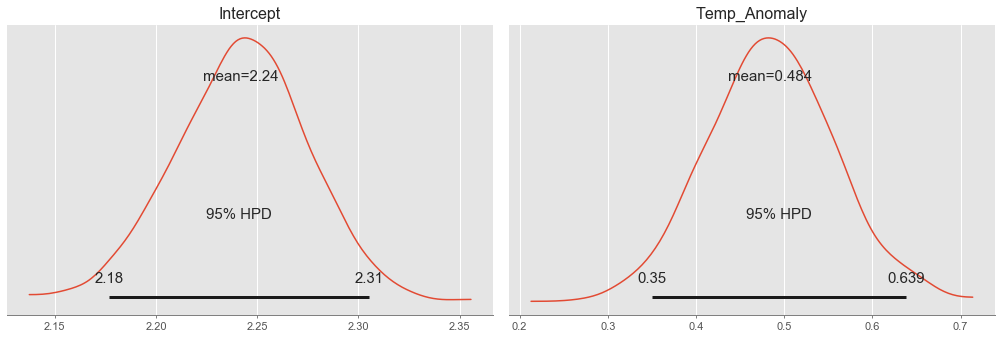

In [21]:
# Plot the posterior distribution for the intercept and Temp_Anomaly coefficients
pm.plot_posterior(trace_poisson, ['Intercept', 'Temp_Anomaly'], credible_interval = 0.95, round_to = 3)
plt.show()

### TODO: Compare the results of `freq_model` in 3.a with the plot above. Are the estimates of Frequentist and Bayesian Regression close to each-other? 

Yes, they look quite similar.

## 3.c Posterior Predictive Checks

In order to validate our Bayesian model we perform Posterior Predictive Checks (PPC). After performing Bayesian Regression we have access to a generating distribution for counts $C'_i|X_i$. The crux of PPC is to sample such counts and to compare them to the original historical data.

The code below computes PPC samples and plots their distribution.

100%|██████████| 2000/2000 [00:01<00:00, 1384.03it/s]
/Users/mcurmei/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


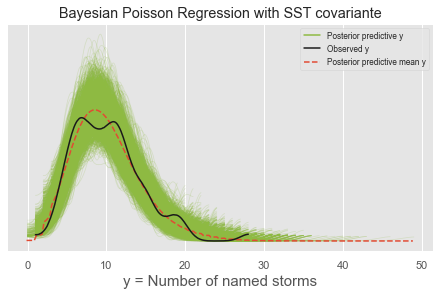

In [20]:
# Do not modify
# Sample C'_i|X_i 
with bayes_model:
        bayes_ppc = pm.sample_posterior_predictive(trace_poisson)
        bayes_ppc['y'] = bayes_ppc['y'] + 0.0
        
# Plot PPC samples
ppc_data = az.from_pymc3(trace_poisson, posterior_predictive=bayes_ppc)
az.plot_ppc(ppc_data)
plt.xlabel('y = Number of named storms')
plt.title('Bayesian Poisson Regression with SST covariante')
plt.show()

### Now let's translate the estimation procedure from  Q.2 into the language of `PYMC3`:

In [21]:
# No TODOs here: Just inspect the code and make sure you understand what is happening
with pm.Model() as simple_bayes_model:
    mu = pm.Gamma('mu', alpha=10, beta=1)
    counts = pm.Poisson('C', mu=mu, observed=df.Num_Storms)
    simple_trace_poisson = pm.sample(1000, cores=2, target_accept=0.95, init='adapt_diag')

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:00<00:00, 3525.91draws/s]


Similarly perform Predictive Posterior Checks

100%|██████████| 2000/2000 [00:00<00:00, 2924.09it/s]
/Users/mcurmei/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


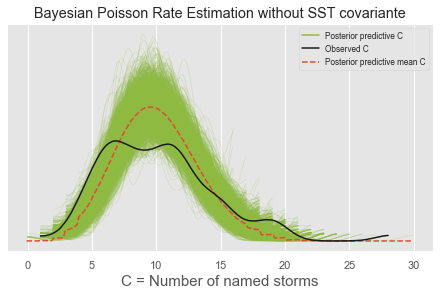

In [22]:
# Do not modify
# Sample C'_i
with simple_bayes_model:
        simple_bayes_ppc = pm.sample_posterior_predictive(simple_trace_poisson)
        simple_bayes_ppc['C'] = simple_bayes_ppc['C'] + 0.0

ppc_data = az.from_pymc3(simple_trace_poisson, posterior_predictive=simple_bayes_ppc)
az.plot_ppc(ppc_data)
plt.xlabel('C = Number of named storms')
plt.title('Bayesian Poisson Rate Estimation without SST covariante')
plt.show()

### TODO: Compare the two plots above. In your opinion, which model is a better fit for the observed data?

The first one seems to fit the data better. Adding an additional variable makes the model better without overfitting.

Fin!


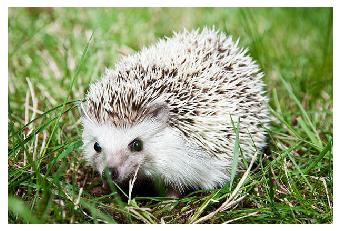

In [23]:
import matplotlib.image as mpimg
img = mpimg.imread('cute_hedgehog.jpg')
imgplot = plt.imshow(img)
imgplot.axes.get_xaxis().set_visible(False)
imgplot.axes.get_yaxis().set_visible(False)
print("Fin!")
plt.show()